In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12138465783085949204
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1749391771
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17251430282698105121
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
INPUT_SHAPE =  (160,160,1) # H ,W ,C , yükseklik , gebişlik , kanal
EPOCHS = 500
BATCH_SIZE = 1


IMG_SHOW_PER_EPOCH = 1 # Her x epochta bir görüntüyü test eder
IMG_SAVE_PER_EPOCH = 100 # Her x (image show)'da bir görüntüyü kaydeder
SHOW_LOG_PER_EPOCH = 1 # Her x epochta bir gidişat grafiğini gösterir
SAVE_MODEL_PER_EPOCH = 5 #Her x epochta bir modeli save eder

MODEL_PATH = "./saved_model"
IMG_SAVE_PATH = "/epochs_images"

In [3]:
import matplotlib.pyplot as plt
def show_images(*images):
    for image in images:
        try:
            n = len(image)
            f = plt.figure()
            for i in range(n):
                # Debug, plot figure
                f.add_subplot(1, n, i + 1) #(satır sayısı,sütun sayısı,index)
                plt.imshow(image[i], cmap='gray', vmin=0, vmax=255)


            plt.show(block=True)
        except:
            image = [image]
            n = len(image)
            f = plt.figure()
            for i in range(n):
                # Debug, plot figure
                f.add_subplot(1, n, i + 1) #(satır sayısı,sütun sayısı,index)
                plt.imshow(image[i], cmap='gray', vmin=0, vmax=255)


            plt.show(block=True)

In [4]:
from PIL import Image
from IPython.display import clear_output #for döngüleriyle yapılan işlemlerin daha düzgün görünmesi için
from tqdm import tqdm #  döngü sürecinin görselleştirilmesi için
import os
import numpy as np
import cv2
import pandas as pd

In [5]:
def import_images(list_of_photo_names,WIDTH,HEIGHT,channel=3):
    
    #isimlerinden fotoğrafları içeri aktar
    photos = []
    sayac = 1
    for im in tqdm(list_of_photo_names):
        im = np.array(Image.open(im).resize((WIDTH,HEIGHT)))
        
        if channel == 1:
            im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        if channel == 3:
            pass
        sayac+=1
        photos.append(im)
        print("importing image: ",sayac)
        clear_output()
    return photos

In [6]:
train_path = os.listdir("./Dataset/Train/")
os.chdir("./Dataset/Train")
train_dataset = import_images(train_path[0:16],160,160,1)
train_dataset = np.array(train_dataset)
os.chdir("..")
os.chdir("..")

print("train dataset : ", len(train_dataset))

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 333.34it/s]

train dataset :  16


In [7]:
test_path = os.listdir("./Dataset/Test/")
os.chdir("./Dataset/Test")
test_dataset = import_images(test_path[0:5],160,160,1)
test_dataset = np.array(test_dataset)
os.chdir("..")
os.chdir("..")

print("test dataset : ", len(test_dataset))

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 416.40it/s]

test dataset :  5


#### Bölütleme fonksiyonları

In [8]:
part_length = 40
slice_x_part_length = 30
slice_y_part_length = 10


## slice_categorie : 0->aşağı 1->sağa 2->yukarı 3->sola
slice_cat_down = 0
slice_cat_right = 1
slice_cat_up = 2
slice_cat_left = 3

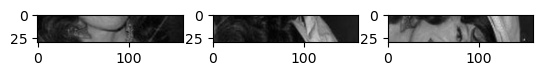

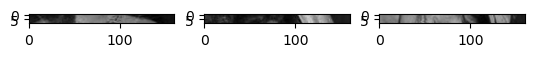

[0 1 1]


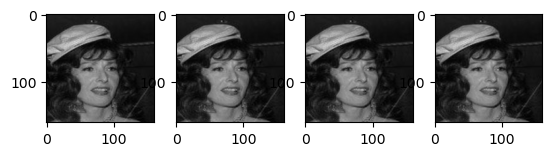

In [9]:
def slice(img,cat):
    x_parts = []
    y_parts = []
    slice_categorie = []
    if cat == 0:
        slice_cat = slice_cat_down
    elif cat == 1:

        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        slice_cat = slice_cat_right       
    elif cat == 2:
        img = cv2.rotate(img, cv2.ROTATE_180)
        slice_cat = slice_cat_up
    elif cat == 3:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        slice_cat = slice_cat_left
    
    for sayac in range(4):
        slice = img[sayac * part_length:sayac*part_length + part_length]
    
        x_part = slice[0:slice_x_part_length]
        y_part = slice[slice_x_part_length : slice_x_part_length + slice_y_part_length]
        
        
        #show_images(slice)
        #print(sayac)
        #show_images(x_part,y_part)
        x_parts.append(x_part)
        y_parts.append(y_part)
        slice_categorie.append(slice_cat)
    return x_parts,y_parts,slice_categorie


def deslice(x_images,y_images,categories):
    image = np.concatenate((
    x_images[0],y_images[0],x_images[1],y_images[1],x_images[2],y_images[2],x_images[3],y_images[3],)
                           ,axis=0)
    if   0 in categories:
        pass
    elif 1 in categories:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif 2 in categories:
        image = cv2.rotate(image, cv2.ROTATE_180)
    elif 3 in categories:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return image
"""
x,y,c = slice(test_dataset[0],0)
show_images(x,y)
#print(c)
im = deslice(x,y,c)
show_images(im)
"""
def slice_sequentially(img):
    x = []
    y = []
    c = []
    onehot_c = []
    for i in range(4):
        x_parts,y_parts,cats = slice(img,i)
        x.append(x_parts)
        y.append(y_parts)
        c.append(cats)
    x = np.array(x)
    y = np.array(y)
    c = np.array(c)
    
    x = np.reshape(x,(x.shape[0] * x.shape[1] , x.shape[2] , x.shape[3]))
    y = np.reshape(y,(y.shape[0] * y.shape[1] , y.shape[2] , y.shape[3]))
    c = np.reshape(c,(c.shape[0] * c.shape[1]))

    return x,y,c
test_a,test_b,test_c = slice_sequentially(test_dataset[0])
show_images(test_a[3:6],test_b[3:6])
print(test_c[3:6])

def deslice_sequentially(x_images,y_images,categories):
    images = []
    for i in range(4):
        im = deslice(x_images[i*4:i*4+4],y_images[i*4:i*4+4],categories[i*4:i*4+4])
        images.append(im)
    return images

test_im = deslice_sequentially(test_a,test_b,test_c)
show_images(test_im)

def slice_for_batch(images):
    xl = []
    yl = []
    cl = []
    
    for im in images:
        x,y,c = slice_sequentially(im)
        xl.append(x)
        yl.append(y)
        cl.append(c)
    xl = np.array(xl)
    yl = np.array(yl)
    cl = np.array(cl)
    xl = np.reshape(xl,(xl.shape[0] * xl.shape[1]  ,  xl.shape[2], xl.shape[3]))
    yl = np.reshape(yl,(yl.shape[0] * yl.shape[1]  ,  yl.shape[2], yl.shape[3]))
    cl = np.reshape(cl,(cl.shape[0] * cl.shape[1]))
    return xl,yl,cl
t1,t2,t3 = slice_for_batch(test_dataset[0:2])

#### Scaling Fonksiyonları

In [10]:
def scale_im_zero_one(images):
    imgs = []
    for im in images:
        if type(im) != 'numpy.ndarray':
            im = np.array(im)
        im = im / 255
        imgs.append(im)
    
    if type(imgs) != 'numpyndarray':
        imgs = np.array(imgs)
        
    if len(imgs) == 1:
        return imgs[0]
    else:
        return imgs
def descale_im_zero_one(images):
    imgs = []
    for im in images:
        if type(im) != 'numpy.ndarray':
            im = np.array(im)
        im = im * 255
        imgs.append(im)
    
        
    if type(imgs) != 'numpyndarray':
        imgs = np.array(imgs)
        
    if len(imgs) == 1:
        return imgs[0]
    else:
        return imgs

def scale_im_minusone_one(images):
    imgs = []
    for im in images:
        if type(im) != 'numpy.ndarray':
            im = np.array(im)
        im = (im -127.5) / 127.5
        imgs.append(im)
    
        
    if type(imgs) != 'numpyndarray':
        imgs = np.array(imgs)
        
    if len(imgs) == 1:
        return imgs[0]
    else:
        return imgs
def descale_im_minusone_one(images):
    imgs = []
    for im in images:
        if type(im) != 'numpy.ndarray':
            im = np.array(im)
        im = (im * 127.5) + 127.5
        imgs.append(im)
    
        
    if type(imgs) != 'numpyndarray':
        imgs = np.array(imgs)
        
    if len(imgs) == 1:
        return imgs[0]
    else:
        return imgs

#### modeli kaydetme - log tutma fonksiyonları

In [11]:
"""Modeli hdf5 ve json formatında kaydet"""
def save_model():
    global disc, gen
    models = [disc, gen]
    model_names = ['disc','gen']

    for model, model_name in zip(models, model_names):
        model_path =  MODEL_PATH + "/%s.json" % model_name
        weights_path = MODEL_PATH + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Model Saved")
    
"""Modeli yükle"""    
def load_model():
    # Checking if all the model exists
    model_names = ['disc', 'gen']
    files = os.listdir(MODEL_PATH)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global disc, gen, gan_model, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = MODEL_PATH + "/%s.json" % 'disc'
    weight_path = MODEL_PATH + "/%s.hdf5" % 'disc'
    with open(model_path, 'r') as f:
        disc = model_from_json(f.read())
    disc.load_weights(weight_path)
    disc.compile(loss="binary_crossentropy", optimizer=SGD)
    
    #load GEN Model
    model_path = MODEL_PATH + "/%s.json" % 'gen'
    weight_path = MODEL_PATH + "/%s.hdf5" % 'gen'
    with open(model_path, 'r') as f:
         gen = model_from_json(f.read())
    gen.load_weights(weight_path)
    
    

    # Combined Model#####################################################BURAYI DEĞİŞTİR
    gan_model = gan_model(gen,disc)
    
    print("loaded model")
    
"""her step başına kayıt al"""
def save_log_with_steps(epoch,step,disc_loss,gen_loss,identity_loss):
    with open("log.txt",mode="a") as f:
        f.write(f"epoch : {epoch} , step : {step} , disc_loss1 : {disc_loss} , disc_loss2: {gen_loss} , gen_loss : {identity_loss}\n") 
    
def get_log_values():
    if "log.txt" not in os.listdir():
        with open("log.txt","x") as f:
            pass
    with open("log.txt","r") as f:
        log = f.readlines()
    epochs = []
    steps = []
    disc_loss = []
    gen_loss = []
    identity_loss = []
    for row in log:
        elements = row.split(",")
        for index,element in enumerate(elements):
            
            numeric_element = element.split(":")[1]
            if   index == 0:
                epochs.append(int(numeric_element))
            elif index == 1:
                steps.append(int(numeric_element))
            elif index == 2:
                disc_loss.append(float(numeric_element))
            elif index == 3:
                gen_loss.append(float(numeric_element))
            elif index == 4:
                identity_loss.append(float(numeric_element))
    return epochs,steps,disc_loss,gen_loss,identity_loss

    
def show_log_plot():
    
    epochs,steps,disc_loss_real,disc_loss_fake,gen_loss= get_log_values()
    epochs = range(len(epochs))
    disc_loss_fake = np.array(disc_loss_fake)
    disc_loss_real= np.array(disc_loss_real)
    gen_loss = np.array(gen_loss)
    
    plt.plot(epochs,disc_loss_fake,'g',label="discriminator fake loss")
    plt.plot(epochs,disc_loss_real,'b',label="discriminator real loss")
    plt.plot(epochs,gen_loss,'r',label="generator loss")
    plt.ylim([0,0.2])
    plt.legend(loc='best')
    
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"./epochs_graphs/figure_{len(epochs)}.jpg")    
    plt.show()


#### Eğitim sırasında kullanılmasıs gereken fonksiyonlar

In [12]:
def save_image(images,epoch):
    for i , im in enumerate(images):
        cv2.imwrite('.{}/{}_image_at_epoch__{:04d}.png'.format(IMG_SAVE_PATH,i,epoch),im)
        
def test_images(gen,images,epoch):
    for im in images:
        pre_x,y,c =slice_sequentially(im)
        x = scale_im_zero_one(pre_x)
        y = scale_im_zero_one(y)
        predicted = gen.predict([x,c])
        predicted = np.reshape(predicted,(16,10,160))
        predicted = descale_im_zero_one(predicted)
        im = deslice(pre_x,predicted,c)
        show_images(im)
        if epoch % IMG_SAVE_PER_EPOCH == 0:
                save_image(im[0:1],epoch)
        
    ###############################33 değişmesi gerekiyor olabilir
def numune(gen,images,cat,number_categorie=4):
    n = len(images)
    
    predicted = gen.predict([images, cat])
    cat_labels = np.random.randint(0, number_categorie, n)
    return predicted, cat_labels

In [13]:
#test_p , test_l = numune(gen,test_a,test_c)
#show_images(test_p[0:4])
#print(test_l)

In [23]:
from keras.layers import Conv2D,UpSampling2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten,MaxPooling2D
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape ,LeakyReLU,Embedding
from keras.models import Model,model_from_json ,Sequential
from keras.optimizers import RMSprop ,Adam ,SGD
from keras.losses import SparseCategoricalCrossentropy

### Generator

In [15]:
def generator(gen_input_shape=(30,160,1),number_categorie=4):
    label_input = Input(shape=(1,))
    label = Embedding(number_categorie,50)(label_input)
    label = Dense(gen_input_shape[0] * gen_input_shape[1])(label)
    label = Reshape(gen_input_shape)(label)
    
    im_input = Input(shape=gen_input_shape)
    c1 = Concatenate()([im_input,label])
    
    
    c1 = Conv2D(128,(3,3),(1,1),dilation_rate=(2,2),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(96,(5,5),(1,1),dilation_rate=(2,2),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2DTranspose(96,(3,3),(2,2),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(96,(3,3),(2,1),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(96,(5,5),(3,2),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(96,(5,5),(1,1),dilation_rate=(2,2),padding="same")(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(96,(3,3),(1,1),dilation_rate=(2,2),padding="same")(c1)
    output = Dense(1,activation="sigmoid")(c1)
    model = Model([im_input,label_input],output)
    return model

gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        200         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 4800)      244800      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 30, 160, 1)  0           []                               
                                ]                                                             

1/1 [==============================] - 4s 4s/step


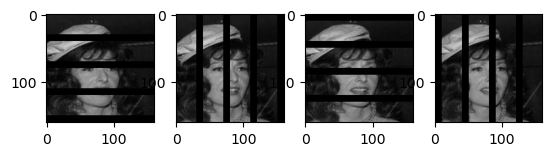

In [16]:
test_predicted = gen.predict([test_a,test_c])
test_predicted = np.reshape(test_predicted,(16,10,160))
test_im = deslice_sequentially(test_a,test_predicted,test_c)
show_images(test_im)

### Discriminator

In [18]:
def discriminator(disc_input_shape=(10,160,1),number_categorie=4):
    label_input = Input(shape=(1,))
    label = Embedding(number_categorie,50)(label_input)
    label = Dense(disc_input_shape[0] * disc_input_shape[1])(label)
    label = Reshape(disc_input_shape)(label)

    im_input = Input(shape=disc_input_shape)

    c1 = Concatenate()([im_input,label])
    c1 = LeakyReLU()(c1)
    c1 = Conv2D(128,(3,3),(1,1),dilation_rate=(2,2),padding="same")(c1)
    c1 = LeakyReLU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(96,(5,5),(1,1),dilation_rate=(2,2),padding="same")(c1)
    c1 = LeakyReLU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(72,(3,3),(2,2),padding="valid")(c1)
    c1 = LeakyReLU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64,(3,3),(1,1),padding="valid")(c1)
    c1 = LeakyReLU()(c1)
    f = Flatten()(c1)
    
    output = Dense(1,activation="softmax")(f)
    model = Model([im_input,label_input],output)
    model.compile(loss=SparseCategoricalCrossentropy, optimizer=SGD(learning_rate=0.02),run_eagerly=False,metrics=["accuracy"])
    return model
disc = discriminator()
disc.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        200         ['input_5[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1, 1600)      81600       ['embedding_2[0][0]']            
                                                                                                  
 input_6 (InputLayer)           [(None, 10, 160, 1)  0           []                               
                                ]                                                           

In [19]:
test_result = disc([test_predicted,test_c])
print(test_result)

tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(16, 1), dtype=float32)


### Model

In [20]:
def gan_model(generator,discriminator):
    discriminator.trainable = False
    
    gen_im_input , gen_label_input = generator.input
    gen_output = generator.output
    
    gan_output = discriminator([gen_output,gen_label_input])
    
    model = Model([gen_im_input,gen_label_input],gan_output)
    model.compile(loss='sparseCategoricalCrossentropy', optimizer=Adam(),run_eagerly=False)
    return model
gan_model = gan_model(gen,disc)
gan_model.summary()
gan_model.trainable = False
test_result = gan_model([test_a,test_c])

gan_model.trainable = True
print(test_result)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        200         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 4800)      244800      ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 30, 160, 1)  0           []                               
                                ]                                                           

### Train

In [21]:
from tqdm import tqdm
from IPython import display
from datetime import datetime

def train():   
    for epoch in tqdm(range(0, EPOCHS)):
        #EPOCH
        
        if epoch % SHOW_LOG_PER_EPOCH == 0:
            show_log_plot()
        if epoch % IMG_SHOW_PER_EPOCH == 0:
            test_images(gen,test_dataset[0:4],epoch)
        if epoch % SAVE_MODEL_PER_EPOCH == 0:
            save_model()

       
                
        steps = 1
        batch_length = int(len(train_dataset) / BATCH_SIZE)
        #BATCH
        for i in range(batch_length):
            
            images = train_dataset[i*BATCH_SIZE:i*BATCH_SIZE + BATCH_SIZE]
            if images is None:
                print("resim yok")
                break
            
           
            x , y , cat = slice_for_batch(images)
            
            x = scale_im_zero_one(x)
            y = scale_im_zero_one(y)
            
            #Discriminator eğit
            disc.trainable = True
            #gerçek veriler ile eğit
            y1 = np.ones((BATCH_SIZE * 16, 1))
            disc_loss1 , _ = disc.train_on_batch([y,cat],y1)
            
            #sahte veriler ile eğit
            y2 = np.zeros((BATCH_SIZE * 16, 1))
            predicted_y , predicted_label = numune(gen,x,cat)
            #predicted_y = scale_im_zero_one(predicted_y)
            disc_loss2 , _ = disc.train_on_batch([predicted_y,predicted_label],y2)
            
            gen.trainable = True
            gan_model.trainable = True
            disc.trainable = False
            #Generator eğit
            y3  = np.ones((BATCH_SIZE * 16, 1))
            gen_loss = gan_model.train_on_batch([x,cat],y3)
                        
            
            steps += 1
            save_log_with_steps(epoch,steps,disc_loss1,disc_loss2,gen_loss)
            print(f"epochs : {epoch} steps : {steps} disc_loss1 : {disc_loss1} disc_loss2 : {disc_loss2} gen_loss : {gen_loss}")
        clear_output(wait=True)
        
        
        

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

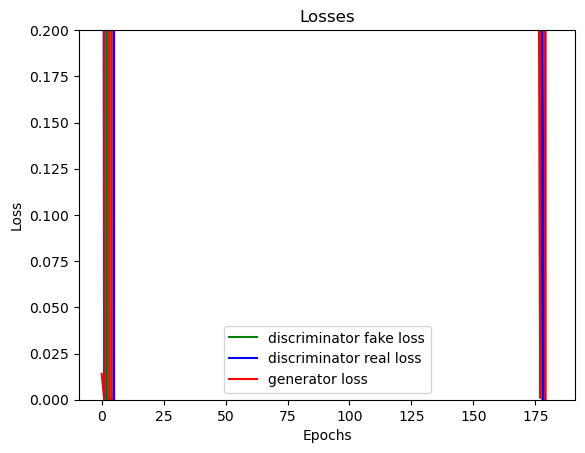

1/1 [==============================] - 0s 249ms/step


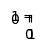

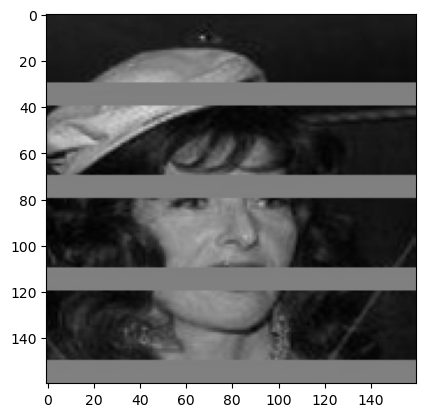

1/1 [==============================] - 0s 117ms/step


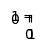

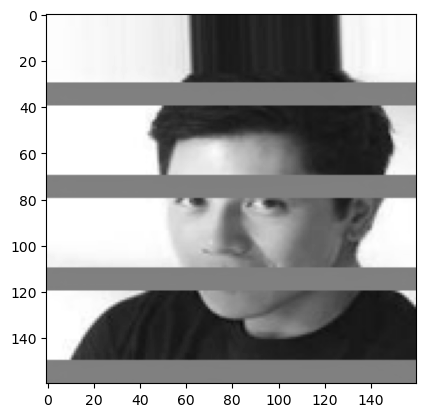

1/1 [==============================] - 0s 115ms/step


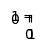

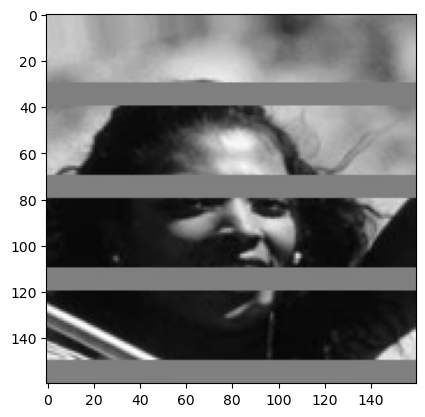

1/1 [==============================] - 0s 118ms/step


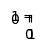

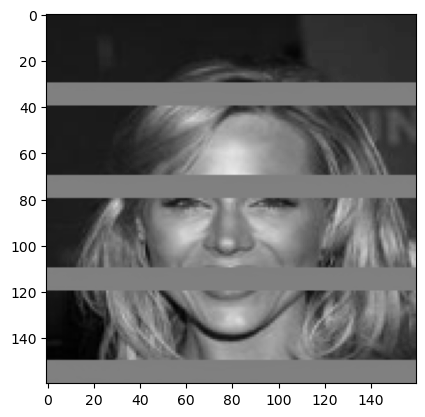

Model Saved


  0%|                                                                                          | 0/500 [00:04<?, ?it/s]


ValueError: in user code:

    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\compile_utils.py", line 182, in build
        self._losses = tf.nest.map_structure(
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\engine\compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\losses.py", line 2649, in get
        return deserialize(identifier)
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\losses.py", line 2603, in deserialize
        return deserialize_keras_object(
    File "C:\Users\Asus\anaconda3\envs\GPU\lib\site-packages\keras\utils\generic_utils.py", line 769, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: sparseCategoricalCrossentropy. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [22]:
train()

In [ ]:
save_model()

In [ ]:
os.getcwd()

In [ ]:
load_model()

In [ ]:
show_log_plot()

In [ ]:
b = gen.predict([test_a,test_c])
b = np.reshape(b,(16,10,160))
print(b.shape)
show_images(b[0])
print(b[0])

In [ ]:

disc.optimizer.learning_rate = 0.5

In [ ]:
q = gen.predict([scale_im_zero_one(test_a),scale_im_zero_one(test_c)])

In [ ]:
q.min()
show_images(q[0])
t = descale_im_zero_one(q)
show_images(t[0])
print(t.max(),t.min())